In [1]:
import logging
import meteoblue_dataset_sdk
import os
import pandas as pd
import numpy as np
import time
import dateutil.parser
import matplotlib.pyplot as plt
# Display information about the current download state
logging.basicConfig(level=logging.INFO)

In [2]:
# some functions...
def map_ts(time):
    if "-" not in time:
        return time
    return dateutil.parser.parse(time.partition("-")[0])

def meteoblue_timeinterval_to_timestamps(t):
    if len(t.timestrings) > 0:
        return list(map(map_ts, t.timestrings))

    timerange = range(t.start, t.end, t.stride)
    # return list(map(lambda t: dt.datetime.fromtimestamp(t), timerange))
    return list(timerange)

def meteoblue_result_to_dataframe(geometry):
    t = geometry.timeIntervals[0]
    timestamps = meteoblue_timeinterval_to_timestamps(t)

    n_locations = len(geometry.lats)
    n_timesteps = len(timestamps)
    print(type(timestamps[0]))

    df = pd.DataFrame(
        {
            "timestamp": np.tile(timestamps, n_locations),
            "id": np.repeat(geometry.locationNames, n_timesteps),
            "Longitude": np.repeat(geometry.lons, n_timesteps),
            "Latitude": np.repeat(geometry.lats, n_timesteps),
            "Elevation": np.repeat(geometry.asls, n_timesteps),
        }
    )

    for code in geometry.codes:
        name = str(code.code) + "_" + code.level + "_" + code.aggregation
        df[name] = list(code.timeIntervals[0].data)
    return df

def measurements_to_dataframe(measurements):
    df = pd.DataFrame()
    for col in measurements.columns:
        name = str(col.column)
        col_type = col.values.WhichOneof("oneof_values")
        if col_type == "strings":
            df[name] = col.values.strings.array
        elif col_type == "floats":
            df[name] = col.values.floats.array
        elif col_type == "ints64":
            df[name] = col.values.ints64.array
        elif col_type == "ints32":
            df[name] = col.values.ints32.array
        elif col_type == "uints64":
            df[name] = col.values.uint64.array
        elif col_type == "uints32":
            df[name] = col.values.uints32.array
        elif col_type == "bools":
            df[name] = col.values.bools.array
    return df

def rmse(df, name1, name2):
    rmse = np.sqrt(((df[name1] - df[name2])**2).mean()) # pandas.DataFrame.mean, skipna defaults to true
    return rmse

def mae(df, name1, name2):
    mae = (np.abs(df[name1] - df[name2])).mean() # pandas.DataFrame.mean, skipna defaults to true
    return mae

def corr_pearsonr(df, name1, name2):
    # remove missing values
    nan_mask = ~(np.isnan(df[name1]) | np.isnan(df[name2]))
    corr = np.corrcoef(df[name1][nan_mask], df[name2][nan_mask])
    return corr[0, 1] # Pearson R is equal to non diagonal elements

In [3]:
## query measurement data for time interval
path = "/dwdClimateHourly/raw/measurement/get"
name_variable_measured = "temperature_2mAbvGnd_atTimestamp_none_degCels"
query = {
    "timeStart": "2020-01-01T00:00:00",
    "timeEnd": "2020-12-31T23:00:00",
    "limit": 10000,
    "fields": [
        "id",
        "timestamp",
        "lat",
        "lon",
        "asl",
        name_variable_measured
    ],
    "stations": ["00691"],
    "sort": "asc"
    }

client = meteoblue_dataset_sdk.Client(apikey=os.environ["APIKEY"]) # apikey has to be saved in your environment
measurements_queried = client.measurement_sync(path, query)
measurements_df = measurements_to_dataframe(measurements_queried)

# set coordinates and station_name for request of modeled data
# this only works if only one station is selected in the above request
lat = measurements_df["lat"][0]
lon = measurements_df["lon"][0]
asl = measurements_df["asl"][0]
station_name = measurements_df["id"][0]

measurements_df

,id,timestamp,lat,lon,asl,temperature_2mAbvGnd_atTimestamp_none_degCels
0,00691,1577836800,53.044998,8.7979,4.28,-1.8
1,00691,1577840400,53.044998,8.7979,4.28,-0.9
2,00691,1577844000,53.044998,8.7979,4.28,-2.2
3,00691,1577847600,53.044998,8.7979,4.28,-3.3
4,00691,1577851200,53.044998,8.7979,4.28,-2.7
...,...,...,...,...,...,...
8779,00691,1609441200,53.044998,8.7979,4.28,2.2
8780,00691,1609444800,53.044998,8.7979,4.28,1.0
8781,00691,1609448400,53.044998,8.7979,4.28,1.2
8782,00691,1609452000,53.044998,8.7979,4.28,1.2


In [4]:
## get model data for same time interval
query = {
    "units": {
        "temperature": "C",
        "velocity": "m/s",
        "length": "metric",
        "energy": "watts",
    },
    "geometry": {
        "type": "MultiPoint",
        "coordinates": [[lon, lat, asl]],
        "locationNames": [station_name],
    },
    "format": "protobuf",
    "timeIntervals": ["2020-01-01T+00:00/2020-12-31T+00:00"],
    "timeIntervalsAlignment": "none",
    "queries": [
        {
            "domain": "ICON",
            "gapFillDomain": None,
            "timeResolution": "hourly",
            "codes": [
                {
                    "code": 11,
                    "level": "2 m above gnd"
                }
            ]
        }
    ],
}
client = meteoblue_dataset_sdk.Client(apikey=os.environ["APIKEY"])
result = client.query_sync(query)
model_df = meteoblue_result_to_dataframe(result.geometries[0])
name_variable_modeled = "11_2 m above gnd_none"

model_df

INFO:root:Starting job without job queue
<class 'int'>


,timestamp,id,Longitude,Latitude,Elevation,11_2 m above gnd_none
0,1577836800,00691,8.75,53.0,26.485321,2.690000
1,1577840400,00691,8.75,53.0,26.485321,2.299630
2,1577844000,00691,8.75,53.0,26.485321,1.747037
3,1577847600,00691,8.75,53.0,26.485321,1.230000
4,1577851200,00691,8.75,53.0,26.485321,0.800370
...,...,...,...,...,...,...
8779,1609441200,00691,8.75,53.0,26.485321,1.166423
8780,1609444800,00691,8.75,53.0,26.485321,0.629135
8781,1609448400,00691,8.75,53.0,26.485321,0.240000
8782,1609452000,00691,8.75,53.0,26.485321,0.240000


In [5]:
merged = pd.merge(model_df, measurements_df, on=["timestamp", "id"]) # merge the two data-frames
merged['timestamp'] = pd.to_datetime(merged['timestamp'], unit='s') # convert unixtimestamp to DateTime-obj

person_r = corr_pearsonr(merged, name_variable_measured, name_variable_modeled)
print("Correlation: ",  person_r)

rms_error = rmse(merged, name_variable_measured, name_variable_modeled)
print("RMSE: ", rms_error)

ma_error = mae(merged, name_variable_measured, name_variable_modeled)
print("MAE: ", ma_error)

Correlation:  0.9821382063689802
RMSE:  1.2485008366074792
MAE:  0.970735735254861


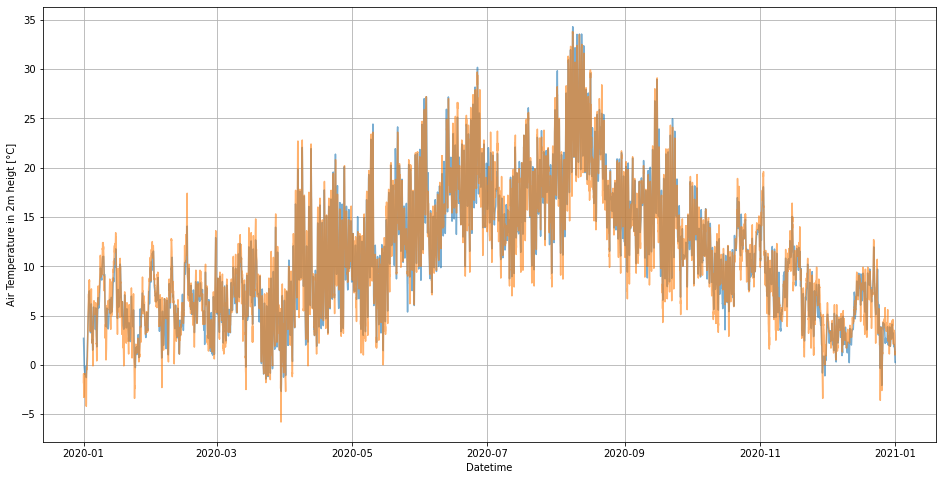

In [6]:
plt.figure(figsize=(16,8))
plt.plot(merged["timestamp"], merged[name_variable_modeled], alpha = 0.6)
plt.plot(merged["timestamp"], merged[name_variable_measured], alpha = 0.6)
plt.grid()
plt.ylabel("Air Temperature in 2m heigt [°C]")
plt.xlabel("Datetime")
plt.show()